**Outline**

The purpose of this script is to plot grand-average TFRs and mu/beta timecourses from the MNS_longISI and buttonPress tasks

**Import packages**

In [2]:
import os
import mne
import numpy as np
import matplotlib.pyplot as plt
import ast
import pandas as pd
import seaborn as sns

mne.set_log_level('ERROR')

**User input**

In [3]:
# Define task prefix
dataPre = 'MNS_longISI'

# How many subjects?
n = '12'

# Sensor pick
pick = 'C3'

# Source estimation method
methods_sufx='MNE-constrained'

# Define colour palette (colorblind sensitive)
colors =  ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#CC79A7", "#9467BD"] 

# Font size for figures
fontsize = 12

**Define main directories and files**

In [4]:
# Main directories
projectDir = '../'
dataDir = os.path.join(projectDir, 'proc_data')
resultsDir = os.path.join(projectDir, 'results')
supportDir = os.path.join(projectDir, 'support_files')

# Input files
times_fname = os.path.join(resultsDir, f'{dataPre}-sens-tfr-times.npy')
info_fname = os.path.join(resultsDir, f'{dataPre}-sens-tfr-info.fif')
muTCs_fname = os.path.join(resultsDir, f'{dataPre}-trans-cleaned-manRej-{methods_sufx}-baseCorrected-labelMuTCs_N={n}.npy')
betaTCs_fname = os.path.join(resultsDir, f'{dataPre}-trans-cleaned-manRej-{methods_sufx}-baseCorrected-labelBetaTCs_N={n}.npy')
bfs_fname = os.path.join(resultsDir, f'{dataPre}_{pick}_and_label_mu_beta_stats_N={n}.csv')
magns_fname = os.path.join(resultsDir, f'{dataPre}_{pick}_and_label_mu_beta_magnitudes_N={n}.csv')
bad_subjects_fname = os.path.join(supportDir, f'{dataPre}_bad_subjects.txt')


**Load and prepare the data for plotting**

In [5]:
# Load data
muTCs = np.load(muTCs_fname, allow_pickle=True)
betaTCs = np.load(betaTCs_fname, allow_pickle=True)
bfs = pd.read_csv(bfs_fname)
magns = pd.read_csv(magns_fname)

times = np.load(times_fname, allow_pickle=True)
info = mne.io.read_info(info_fname)
ROIs = bfs['label'].unique().tolist()
ROIs.remove(pick)

print(f"times shape: {times.shape}")
print(f"mu timecourses shape: {muTCs.shape}")
print(f"beta timecourses shape: {betaTCs.shape}")



times shape: (6001,)
mu timecourses shape: (12, 6, 6001)
beta timecourses shape: (12, 6, 6001)


In [6]:
# Average the timecourse data across subjects and compute standard errors
gavg_muTC = np.mean(muTCs, axis=0).squeeze()
gavg_betaTC = np.mean(betaTCs, axis=0).squeeze()

se_muTC = np.std(muTCs, axis=0) / np.sqrt(muTCs.shape[0])
se_betaTC = np.std(betaTCs, axis=0) / np.sqrt(betaTCs.shape[0])

se_muTC = se_muTC.squeeze()
se_betaTC = se_betaTC.squeeze()

# Convert bfs and magns to long format for easy plotting
bfs_long = pd.melt(bfs, id_vars=['label'], var_name='effect', value_name='bf')
# Drop na rows
bfs_long = bfs_long.dropna(subset=['bf'])

# Convert magns to long format
magns_long = pd.melt(magns, id_vars=['label'], var_name='effect')

# Split the 'value' column (which contains lists) into separate columns
split_values = magns_long['value'].str.split(',', expand=True)
magns_long = pd.concat([magns_long.drop(columns=['value']), split_values], axis=1)

# Wrangle back to long format
magns_long = magns_long.melt(id_vars=['label', 'effect'],  
											value_name='magnitude')

# Convert the 'magnitude' column to numeric
magns_long['magnitude'] = pd.to_numeric(magns_long['magnitude'], errors='coerce')

# Separate bfs and magnitudes for the selected sensor and labels
bfs_sens = bfs[bfs['label'] == pick]
magns_sens = magns[magns['label'] == pick]

# Split into sensor and label data
bfs_long_sens = bfs_long[bfs_long['label'] == 'C3']
bfs_long_labels = bfs_long[bfs_long['label'] != 'C3']
magns_long_sens = magns_long[magns_long['label'] == 'C3']
magns_long_labels = magns_long[magns_long['label'] != 'C3']

**Plot label timecourses**

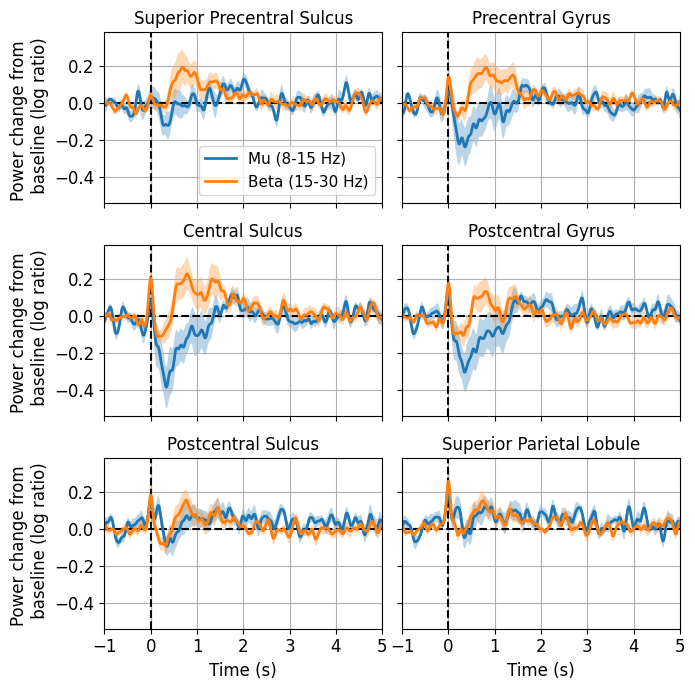

In [7]:
# Define a figure with 1 axis for each ROI
_, axes = plt.subplots(nrows=3, ncols=2, figsize=(7,7), sharex=True, sharey=True)
axes = axes.flatten()

for i, ROI in enumerate(ROIs):
	# roi_index = ROIs.index(ROI)  # Get the correct index for the ROI
	ax = axes[i]

	# Plot a dashed lines at zero
	ax.axhline(0, color='k', linestyle='--')
	ax.axvline(0, color='k', linestyle='--')

	# Plot the mu and beta gavg timecourses
	ax.plot(times, gavg_muTC[i], linewidth=2, label = 'Mu (8-15 Hz)')

	# Add shaded region for standard error
	ax.fill_between(times, gavg_muTC[i] - se_muTC[i],
					gavg_muTC[i] + se_muTC[i], alpha=0.3)

	# Plot the mu and beta gavg timecourses
	ax.plot(times, gavg_betaTC[i], linewidth=2, label = 'Beta (15-30 Hz)')

	# Add shaded region for standard error
	ax.fill_between(times, gavg_betaTC[i] - se_betaTC[i],
					gavg_betaTC[i] + se_betaTC[i], alpha=0.3)
	
	# Set axis params
	ax.set_title(ROIs[i])
	ax.set_xlim(-1, 5)
	ax.grid(which='both')

	for label in (ax.get_xticklabels() + ax.get_yticklabels()):
		label.set_fontsize(fontsize)

	# Include a y label for the left-hand column and an x label for the bottom row
	if i % 2 == 0:
		ax.set_ylabel('Power change from \n baseline (log ratio)', fontsize=fontsize)
	if i > 3:
		ax.set_xlabel('Time (s)', fontsize=fontsize)

	# Show legend in the first subplot
	if i == 0:
		ax.legend(fontsize=fontsize-1)

	# Set text size for axis ticks


plt.tight_layout()



**Plot label magnitudes and BFs**

/tmp/ipykernel_47572/953865931.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(['Mu ERD', 'Beta ERD', 'Beta ERS'], fontsize=fontsize)


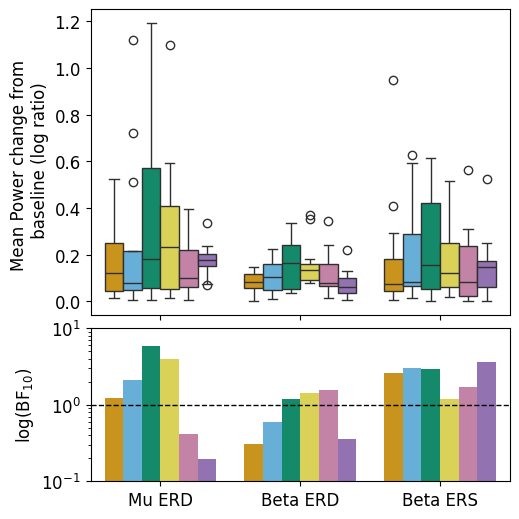

In [8]:
# Create a figure with 2 rows to plot the magnitudes and Bayes factors
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]}, sharex=True, figsize=(5,5))

# Plot the magnitudes
sns.boxplot(data=magns_long_labels, x='effect', y='magnitude', hue='label', palette=colors, showfliers=True, legend=False, ax=ax[0], native_scale=True)
# sns.barplot(data=magns_long_labels, x='effect', y='magnitude', 
# 			hue='label', palette=colors, legend=False, ax=ax[0], errorbar='se', capsize=0.1)

# Plot the Bayes factors
sns.barplot(data=bfs_long_labels,x='effect', y='bf', hue='label', palette=colors, legend=False, ax=ax[1])
ax[1].set_yscale('log')

# Add a line to denote BF = 1
ax[1].axhline(1, color='black', linestyle='--', lw=1)

# Fix y axis ticks
ax[1].set_yticks([0.1, 1, np.round(np.max(bfs_long_labels['bf']), -1)])  # sets max tick to nearest 10

# Axis labels
ax[0].set_ylabel('Mean Power change from \n baseline (log ratio)', fontsize=fontsize)
ax[0].set_xlabel('')
ax[1].set_ylabel('log(BF$_{10}$)', fontsize=fontsize)
ax[1].set_xlabel('')
ax[1].set_xticklabels(['Mu ERD', 'Beta ERD', 'Beta ERS'], fontsize=fontsize)

# Set text size for remaining axis elements
for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels() 
			  + ax[1].get_xticklabels() + ax[1].get_yticklabels()):
	label.set_fontsize(fontsize)

# Adjust layout
plt.tight_layout(pad=0)



In [10]:
# Round values in bf to 2 decimal places
bfs['mu_ERD'] = bfs['mu_ERD'].round(2)
bfs['beta_ERD'] = bfs['beta_ERD'].round(2)
bfs['beta_ERS'] = bfs['beta_ERS'].round(2)

bfs

,label,mu_ERD,beta_ERD,beta_ERS
0,C3,3.17,1.69,5.83
1,Superior Precentral Sulcus,1.21,0.30,2.56
2,Precentral Gyrus,2.12,0.60,3.05
3,Central Sulcus,5.90,1.18,2.97
4,Postcentral Gyrus,3.90,1.44,1.17
5,Postcentral Sulcus,0.42,1.55,1.71
6,Superior Parietal Lobule,0.20,0.35,3.57
